Loading song23_Imputed.mat...
Keys in the .mat file: dict_keys(['__header__', '__version__', '__globals__', 'data23', 'fs', 'subs23'])
subs23 shape: (1, 20)
subs23 contents: [[array(['S02'], dtype='<U3') array(['S03'], dtype='<U3')
  array(['S04'], dtype='<U3') array(['S05'], dtype='<U3')
  array(['S06'], dtype='<U3') array(['S07'], dtype='<U3')
  array(['S08'], dtype='<U3') array(['S09'], dtype='<U3')
  array(['S10'], dtype='<U3') array(['S11'], dtype='<U3')
  array(['S12'], dtype='<U3') array(['S13'], dtype='<U3')
  array(['S14'], dtype='<U3') array(['S15'], dtype='<U3')
  array(['S16'], dtype='<U3') array(['S17'], dtype='<U3')
  array(['S19'], dtype='<U3') array(['S20'], dtype='<U3')
  array(['S21'], dtype='<U3') array(['S23'], dtype='<U3')]]
Available Channels: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz', 'Oz']
Missing Channels: []
All channels are available in the standard montage.
Sampling Frequency: 125 Hz
C

C:\Users\napat\AppData\Local\Temp\ipykernel_9500\3112217315.py:95: RuntimeWarning: overflow encountered in scalar multiply
  epoch_len_samp = int(fs * epochLenSec)  # Total samples in epoch
C:\Users\napat\AppData\Local\Temp\ipykernel_9500\3112217315.py:98: RuntimeWarning: overflow encountered in scalar multiply
  start_idx = sec_start * fs  # 15 seconds into the recording


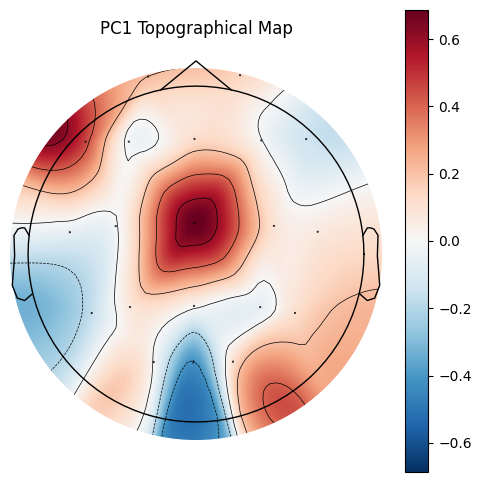

Topographical map saved as 'PC1_Topomap.png'.


In [6]:
import os
import numpy as np
import scipy.io as sio
from sklearn.decomposition import PCA
import mne
import matplotlib.pyplot as plt

# Define directories
in_dir = r'D:\Imputed_file'    # EEG data folder
miscDir = r'C:\Users\napat\Documents\GitHub\BCC_2024\Code\Misc'     # Misc folder (if necessary)

# Define the current file
song_idx = 23
currFn = f'song{song_idx}_Imputed.mat'

# Load the .mat file
print(f'Loading {currFn}...')
mat_file = sio.loadmat(os.path.join(in_dir, currFn))

# Inspect the keys
print("Keys in the .mat file:", mat_file.keys())

# Extract 'subs23' to get channel names (Note: 'subs23' contains subject identifiers, not channel names)
subs23 = mat_file['subs23']
print(f"subs23 shape: {subs23.shape}")
print("subs23 contents:", subs23)

# Define channel names manually based on your EEG setup
channel_names = [
    'Fp1', 'Fp2',
    'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
    'F7', 'F8', 'T3', 'T4', 'T5', 'T6',
    'Fz', 'Cz', 'Pz', 'Oz'
]

# Verify channel count
data23 = mat_file['data23']  # Shape: (125, 34469, 20)
if len(channel_names) != data23.shape[2]:
    raise ValueError(f"Number of channel names ({len(channel_names)}) does not match number of data channels ({data23.shape[2]}).")

# Load the standard 10-20 montage
standard_montage = mne.channels.make_standard_montage('standard_1020')

# Check available and missing channels
available_channels = [ch for ch in channel_names if ch in standard_montage.ch_names]
missing_channels = [ch for ch in channel_names if ch not in standard_montage.ch_names]

print(f"Available Channels: {available_channels}")
print(f"Missing Channels: {missing_channels}")

if missing_channels:
    print("Some channels are missing in the standard montage. Please define their positions manually.")
    # Define custom channel positions if necessary
    # Example:
    # custom_ch_pos = {
    #     'Ch21': (0.1, 0.2, 0.0),
    #     # Add other missing channels here
    # }
    # custom_montage = mne.channels.make_dig_montage(ch_pos=custom_ch_pos, coord_frame='head')
    # standard_montage.ch_pos.update(custom_ch_pos)
    # montage = standard_montage.copy().pick_channels(available_channels + list(custom_ch_pos.keys()))
else:
    print("All channels are available in the standard montage.")

# Create the Info object
fs = mat_file['fs'][0, 0]  # Extract sampling frequency
print(f"Sampling Frequency: {fs} Hz")

info = mne.create_info(ch_names=channel_names, sfreq=fs, ch_types='eeg')

# Assign the standard montage directly to the Info object
info.set_montage(standard_montage)

# Verify channel positions
for ch in info['ch_names']:
    pos = info['chs'][info.ch_names.index(ch)]['loc'][:3]
    print(f"Channel {ch}: Position {pos}")

# Apply DC correction
def median_dc_correct_all_trials(data):

    # Calculate the median across trials (axis=0)
    median_across_trials = np.median(data, axis=0)  # Shape: (samples, channels)
    
    # Subtract the median from each trial
    corrected_data = data - median_across_trials  # Broadcasting over trials
    return corrected_data

tempX_dc = median_dc_correct_all_trials(data23)
print("Applied DC correction.")

# Define epoch parameters
sec_start = 15
epochLenSec = 4 * 60    # 4 minutes
epoch_len_samp = int(fs * epochLenSec)  # Total samples in epoch

# Calculate start and end indices
start_idx = sec_start * fs  # 15 seconds into the recording
end_idx = start_idx + epoch_len_samp

# Verify that end_idx does not exceed the total number of samples
total_samples = tempX_dc.shape[1]
if end_idx > total_samples:
    raise ValueError(f"End index ({end_idx}) exceeds total samples ({total_samples}).")

# Extract epoch
tempX_epoch = tempX_dc[:, start_idx:end_idx, :]  # Shape: (trials, samples, channels)
print(f"Extracted epoch shape: {tempX_epoch.shape}")

# Average over time for each trial
trial_mean = tempX_epoch.mean(axis=1)  # Shape: (trials, channels)
print(f"Trial Mean Shape: {trial_mean.shape}")

# Perform PCA
pca = PCA(n_components=1)
pca.fit(trial_mean)
pc1 = pca.components_[0]  # Shape: (channels,)
explained_variance = pca.explained_variance_ratio_[0]
print(f"PC1 explained variance ratio: {explained_variance}")

# Create an Evoked-like object for plotting
evoked = mne.EvokedArray(pc1[:, np.newaxis], info)

# Plot the topomap
fig, ax = plt.subplots(figsize=(6, 6))
im, cm_map = mne.viz.plot_topomap(pc1, evoked.info, axes=ax, show=False, cmap='RdBu_r')
plt.colorbar(im, ax=ax)
ax.set_title('PC1 Topographical Map')
plt.show()

# Save the figure
fig.savefig('PC1_Topomap_01.png', dpi=300)
print("Topographical map saved as 'PC1_Topomap.png'.")


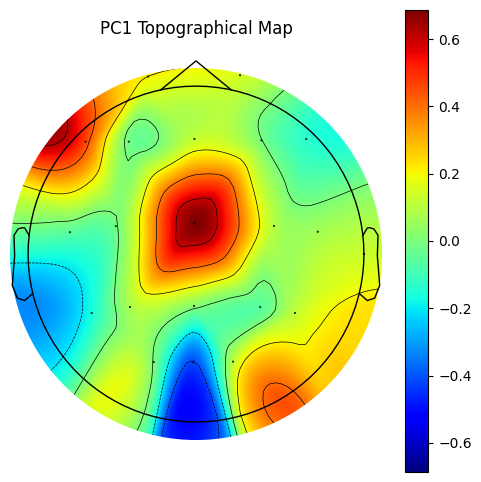

In [2]:
# Adjust colormap
fig, ax = plt.subplots(figsize=(6, 6))
im, cm_map = mne.viz.plot_topomap(pc1, evoked.info, axes=ax, show=False, cmap='jet')
plt.colorbar(im, ax=ax)
ax.set_title('PC1 Topographical Map')
plt.show()


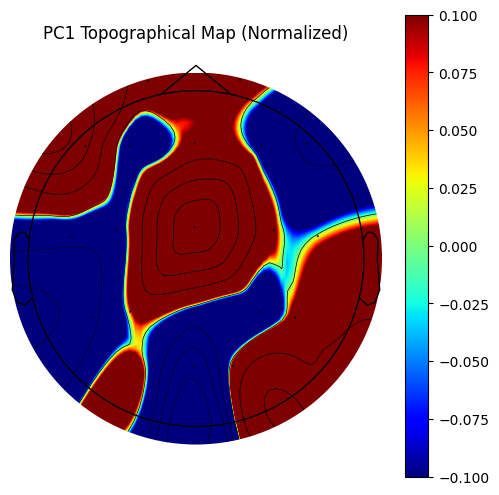

In [7]:
# Normalize PCA values
pc1_normalized = (pc1 - np.mean(pc1)) / np.std(pc1)

# Plot normalized values without specifying vmin/vmax in the function call
fig, ax = plt.subplots(figsize=(6, 6))
im, cm_map = mne.viz.plot_topomap(pc1_normalized, evoked.info, axes=ax, show=False, cmap='jet')

# Manually set the color limits
im.set_clim(vmin=-0.1, vmax=0.1)

# Add colorbar and title
plt.colorbar(im, ax=ax)
ax.set_title('PC1 Topographical Map (Normalized)')
plt.show()


Loading song21_Imputed.mat...
Applied DC correction for song 21.
Extracted epoch shape for song 21: (125, 48, 20)
Trial Mean Shape for song 21: (125, 20)
PC1 explained variance ratio for song 21: 0.2710667124402524


C:\Users\napat\AppData\Local\Temp\ipykernel_9500\1267170410.py:57: RuntimeWarning: overflow encountered in scalar multiply
  epoch_len_samp = int(fs * epochLenSec)  # Total samples in epoch
C:\Users\napat\AppData\Local\Temp\ipykernel_9500\1267170410.py:60: RuntimeWarning: overflow encountered in scalar multiply
  start_idx = sec_start * fs  # 15 seconds into the recording


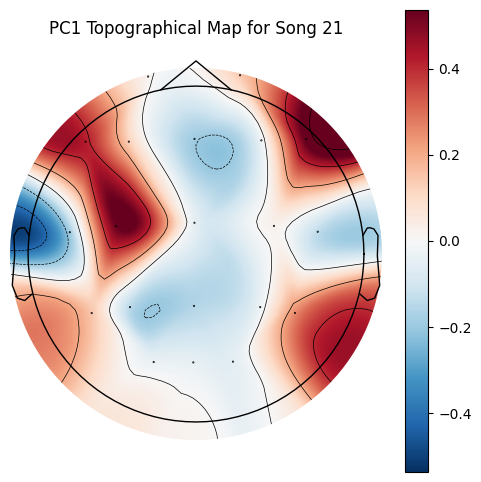

Topographical map for song 21 saved as 'PC1_Topomap_Song_21.png'.
Loading song22_Imputed.mat...
Applied DC correction for song 22.
Extracted epoch shape for song 22: (125, 48, 20)
Trial Mean Shape for song 22: (125, 20)
PC1 explained variance ratio for song 22: 0.4047279803188159


C:\Users\napat\AppData\Local\Temp\ipykernel_9500\1267170410.py:57: RuntimeWarning: overflow encountered in scalar multiply
  epoch_len_samp = int(fs * epochLenSec)  # Total samples in epoch
C:\Users\napat\AppData\Local\Temp\ipykernel_9500\1267170410.py:60: RuntimeWarning: overflow encountered in scalar multiply
  start_idx = sec_start * fs  # 15 seconds into the recording


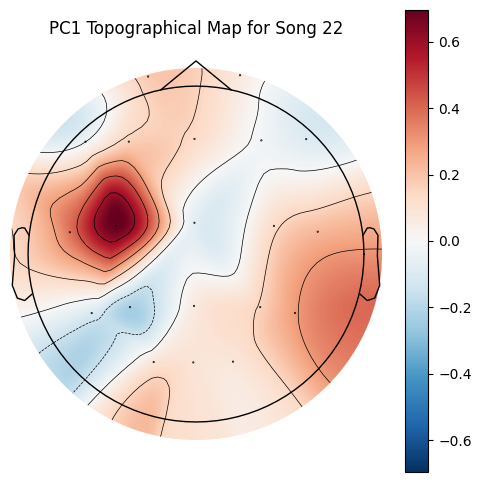

Topographical map for song 22 saved as 'PC1_Topomap_Song_22.png'.
Loading song23_Imputed.mat...
Applied DC correction for song 23.
Extracted epoch shape for song 23: (125, 48, 20)
Trial Mean Shape for song 23: (125, 20)
PC1 explained variance ratio for song 23: 0.26311641234805583


C:\Users\napat\AppData\Local\Temp\ipykernel_9500\1267170410.py:57: RuntimeWarning: overflow encountered in scalar multiply
  epoch_len_samp = int(fs * epochLenSec)  # Total samples in epoch
C:\Users\napat\AppData\Local\Temp\ipykernel_9500\1267170410.py:60: RuntimeWarning: overflow encountered in scalar multiply
  start_idx = sec_start * fs  # 15 seconds into the recording


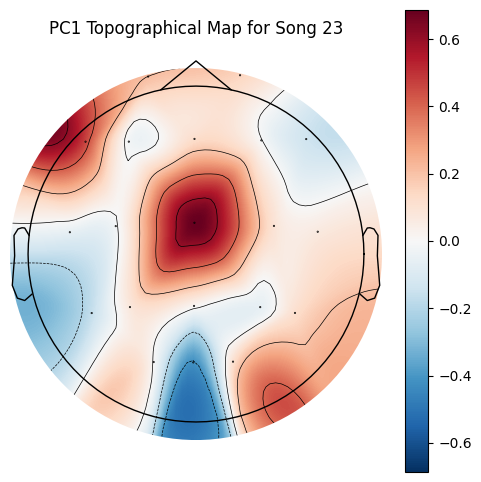

Topographical map for song 23 saved as 'PC1_Topomap_Song_23.png'.
Loading song24_Imputed.mat...
Applied DC correction for song 24.
Extracted epoch shape for song 24: (125, 48, 20)
Trial Mean Shape for song 24: (125, 20)
PC1 explained variance ratio for song 24: 0.33954475597963646


C:\Users\napat\AppData\Local\Temp\ipykernel_9500\1267170410.py:57: RuntimeWarning: overflow encountered in scalar multiply
  epoch_len_samp = int(fs * epochLenSec)  # Total samples in epoch
C:\Users\napat\AppData\Local\Temp\ipykernel_9500\1267170410.py:60: RuntimeWarning: overflow encountered in scalar multiply
  start_idx = sec_start * fs  # 15 seconds into the recording


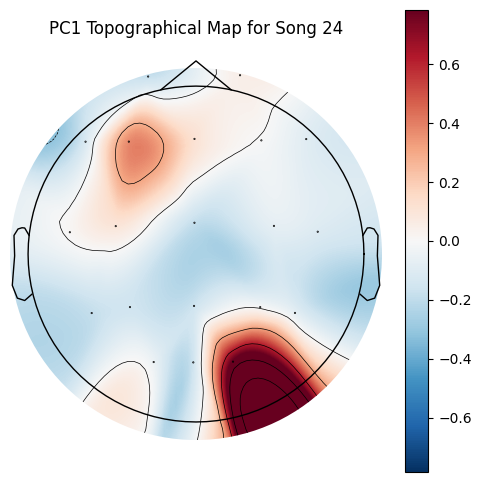

Topographical map for song 24 saved as 'PC1_Topomap_Song_24.png'.
Loading song25_Imputed.mat...
Applied DC correction for song 25.
Extracted epoch shape for song 25: (125, 48, 20)
Trial Mean Shape for song 25: (125, 20)
PC1 explained variance ratio for song 25: 0.2881784748738108


C:\Users\napat\AppData\Local\Temp\ipykernel_9500\1267170410.py:57: RuntimeWarning: overflow encountered in scalar multiply
  epoch_len_samp = int(fs * epochLenSec)  # Total samples in epoch
C:\Users\napat\AppData\Local\Temp\ipykernel_9500\1267170410.py:60: RuntimeWarning: overflow encountered in scalar multiply
  start_idx = sec_start * fs  # 15 seconds into the recording


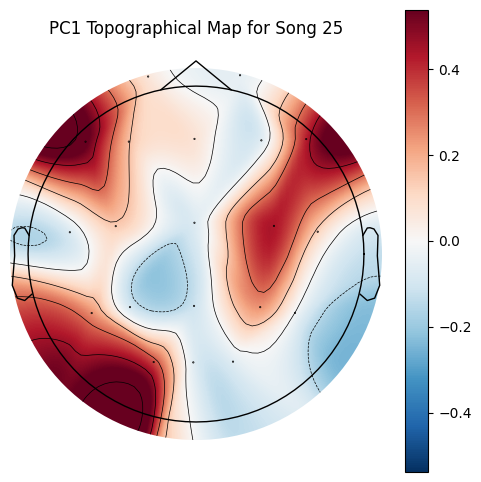

Topographical map for song 25 saved as 'PC1_Topomap_Song_25.png'.
Loading song26_Imputed.mat...
Applied DC correction for song 26.
Extracted epoch shape for song 26: (125, 48, 20)
Trial Mean Shape for song 26: (125, 20)
PC1 explained variance ratio for song 26: 0.38045827270229393


C:\Users\napat\AppData\Local\Temp\ipykernel_9500\1267170410.py:57: RuntimeWarning: overflow encountered in scalar multiply
  epoch_len_samp = int(fs * epochLenSec)  # Total samples in epoch
C:\Users\napat\AppData\Local\Temp\ipykernel_9500\1267170410.py:60: RuntimeWarning: overflow encountered in scalar multiply
  start_idx = sec_start * fs  # 15 seconds into the recording


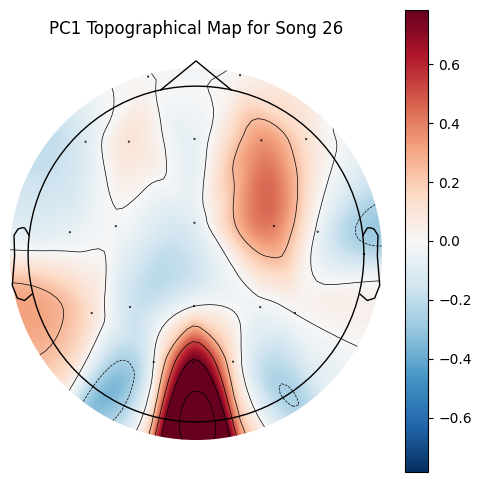

Topographical map for song 26 saved as 'PC1_Topomap_Song_26.png'.
Loading song27_Imputed.mat...
Applied DC correction for song 27.
Extracted epoch shape for song 27: (125, 48, 20)
Trial Mean Shape for song 27: (125, 20)
PC1 explained variance ratio for song 27: 0.3870578634266484


C:\Users\napat\AppData\Local\Temp\ipykernel_9500\1267170410.py:57: RuntimeWarning: overflow encountered in scalar multiply
  epoch_len_samp = int(fs * epochLenSec)  # Total samples in epoch
C:\Users\napat\AppData\Local\Temp\ipykernel_9500\1267170410.py:60: RuntimeWarning: overflow encountered in scalar multiply
  start_idx = sec_start * fs  # 15 seconds into the recording


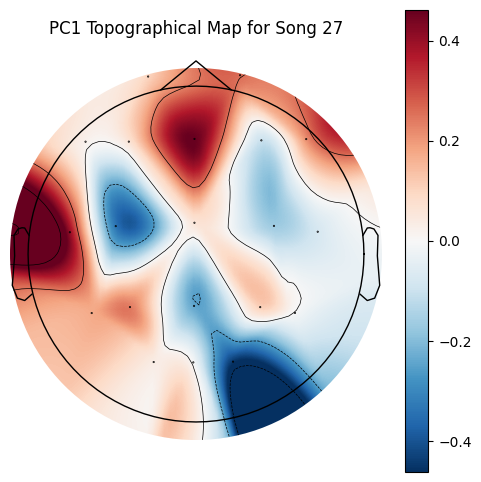

Topographical map for song 27 saved as 'PC1_Topomap_Song_27.png'.
Loading song28_Imputed.mat...
Applied DC correction for song 28.
Extracted epoch shape for song 28: (125, 48, 20)
Trial Mean Shape for song 28: (125, 20)
PC1 explained variance ratio for song 28: 0.30069534184572505


C:\Users\napat\AppData\Local\Temp\ipykernel_9500\1267170410.py:57: RuntimeWarning: overflow encountered in scalar multiply
  epoch_len_samp = int(fs * epochLenSec)  # Total samples in epoch
C:\Users\napat\AppData\Local\Temp\ipykernel_9500\1267170410.py:60: RuntimeWarning: overflow encountered in scalar multiply
  start_idx = sec_start * fs  # 15 seconds into the recording


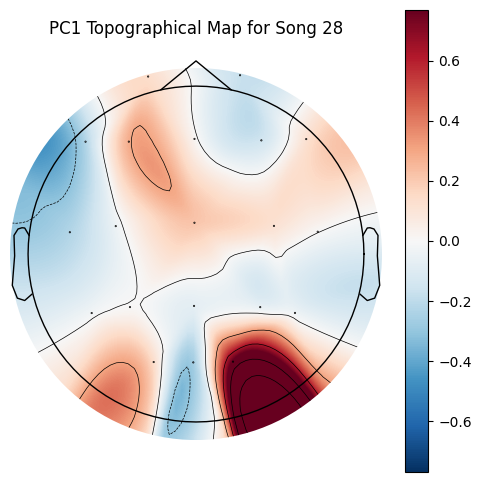

Topographical map for song 28 saved as 'PC1_Topomap_Song_28.png'.
Loading song29_Imputed.mat...
Applied DC correction for song 29.
Extracted epoch shape for song 29: (125, 48, 20)
Trial Mean Shape for song 29: (125, 20)
PC1 explained variance ratio for song 29: 0.298882421817602


C:\Users\napat\AppData\Local\Temp\ipykernel_9500\1267170410.py:57: RuntimeWarning: overflow encountered in scalar multiply
  epoch_len_samp = int(fs * epochLenSec)  # Total samples in epoch
C:\Users\napat\AppData\Local\Temp\ipykernel_9500\1267170410.py:60: RuntimeWarning: overflow encountered in scalar multiply
  start_idx = sec_start * fs  # 15 seconds into the recording


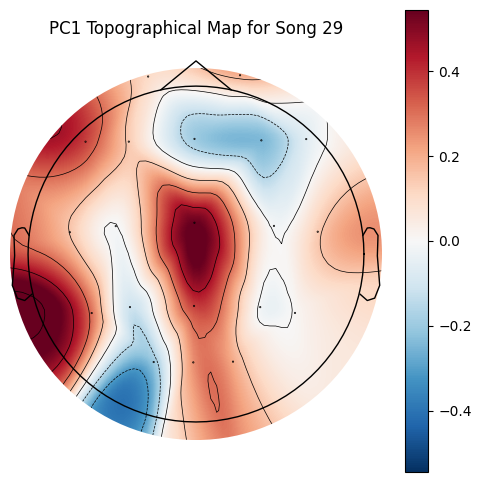

Topographical map for song 29 saved as 'PC1_Topomap_Song_29.png'.
Loading song30_Imputed.mat...
Applied DC correction for song 30.
Extracted epoch shape for song 30: (125, 48, 20)
Trial Mean Shape for song 30: (125, 20)
PC1 explained variance ratio for song 30: 0.3210057599345851


C:\Users\napat\AppData\Local\Temp\ipykernel_9500\1267170410.py:57: RuntimeWarning: overflow encountered in scalar multiply
  epoch_len_samp = int(fs * epochLenSec)  # Total samples in epoch
C:\Users\napat\AppData\Local\Temp\ipykernel_9500\1267170410.py:60: RuntimeWarning: overflow encountered in scalar multiply
  start_idx = sec_start * fs  # 15 seconds into the recording


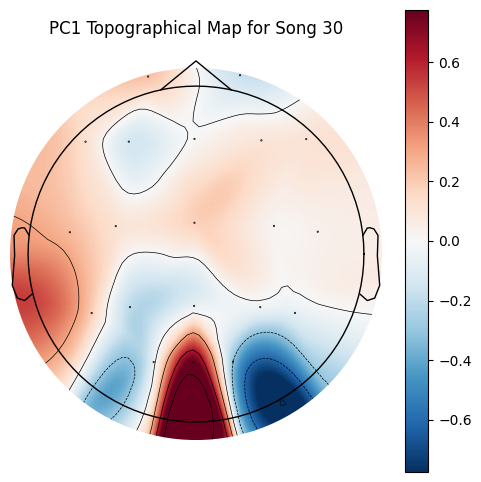

Topographical map for song 30 saved as 'PC1_Topomap_Song_30.png'.


In [10]:
import os
import numpy as np
import scipy.io as sio
from sklearn.decomposition import PCA
import mne
import matplotlib.pyplot as plt

# Define directories
in_dir = r'D:\Imputed_file'  # EEG data folder
miscDir = r'C:\Users\napat\Documents\GitHub\BCC_2024\Code\Misc'  # Misc folder (if necessary)

# Define the range of songs (21 to 30)
song_indices = range(21, 31)

# Define channel names manually based on your EEG setup
channel_names = [
    'Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
    'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz', 'Oz'
]

# Load the standard 10-20 montage
standard_montage = mne.channels.make_standard_montage('standard_1020')

# Loop over all songs (21 to 30)
for song_idx in song_indices:
    currFn = f'song{song_idx}_Imputed.mat'

    # Load the .mat file
    print(f'Loading {currFn}...')
    mat_file = sio.loadmat(os.path.join(in_dir, currFn))

    # Extract the data
    subs23 = mat_file[f'subs{song_idx}']
    data23 = mat_file[f'data{song_idx}']  # Shape: (trials, samples, channels)

    # Verify the number of channels matches
    if len(channel_names) != data23.shape[2]:
        raise ValueError(f"Number of channel names ({len(channel_names)}) does not match number of data channels ({data23.shape[2]}).")

    # Create the Info object
    fs = mat_file['fs'][0, 0]  # Extract sampling frequency
    info = mne.create_info(ch_names=channel_names, sfreq=fs, ch_types='eeg')
    info.set_montage(standard_montage)

    # Apply DC correction
    def median_dc_correct_all_trials(data):
        median_across_trials = np.median(data, axis=0)  # Shape: (samples, channels)
        corrected_data = data - median_across_trials  # Broadcasting over trials
        return corrected_data

    tempX_dc = median_dc_correct_all_trials(data23)
    print(f"Applied DC correction for song {song_idx}.")

    # Define epoch parameters
    sec_start = 15
    epochLenSec = 4 * 60  # 4 minutes
    epoch_len_samp = int(fs * epochLenSec)  # Total samples in epoch

    # Calculate start and end indices
    start_idx = sec_start * fs  # 15 seconds into the recording
    end_idx = start_idx + epoch_len_samp

    # Verify that end_idx does not exceed the total number of samples
    total_samples = tempX_dc.shape[1]
    if end_idx > total_samples:
        raise ValueError(f"End index ({end_idx}) exceeds total samples ({total_samples}).")

    # Extract epoch
    tempX_epoch = tempX_dc[:, start_idx:end_idx, :]  # Shape: (trials, samples, channels)
    print(f"Extracted epoch shape for song {song_idx}: {tempX_epoch.shape}")

    # Average over time for each trial
    trial_mean = tempX_epoch.mean(axis=1)  # Shape: (trials, channels)
    print(f"Trial Mean Shape for song {song_idx}: {trial_mean.shape}")

    # Perform PCA
    pca = PCA(n_components=1)
    pca.fit(trial_mean)
    pc1 = pca.components_[0]  # Shape: (channels,)
    explained_variance = pca.explained_variance_ratio_[0]
    print(f"PC1 explained variance ratio for song {song_idx}: {explained_variance}")

    # Create an Evoked-like object for plotting
    evoked = mne.EvokedArray(pc1[:, np.newaxis], info)

    # Plot the topomap
    fig, ax = plt.subplots(figsize=(6, 6))
    im, cm_map = mne.viz.plot_topomap(pc1, evoked.info, axes=ax, show=False, cmap='RdBu_r')
    plt.colorbar(im, ax=ax)
    ax.set_title(f'PC1 Topographical Map for Song {song_idx}')
    plt.show()

    # Save the figure
    fig_filename = f'PC1_Topomap_Song_{song_idx}.png'
    fig.savefig(fig_filename, dpi=300)
    print(f"Topographical map for song {song_idx} saved as '{fig_filename}'.")
